# Bubble Target Strength Validation

This notebook validates bubble target strength calculations by reproducing **Weber et al. (2014) Figure 1**. 

Weber, T. C., L. Mayer, K. Jerram, J. Beaudoin, Y. Rzhanov, and D. Lovalvo (2014), Acoustic estimates of methane gas flux from the seabed in a 6000 km2 region in the Northern Gulf of Mexico, Geochem. Geophys. Geosyst., 15, 1911–1925, doi:10.1002/2014GC005271.

## Import Required Libraries

Import necessary libraries including NumPy, Matplotlib, and custom SeaEcho modules for water bubble calculations.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import importlib

# Add project root to path for imports (go up one level from validation folder)
PROJECT_ROOT = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Import SeaEcho modules
from utils.SeaEcho_water import seawater  
from utils.SeaEcho_gas_bubble import air_bubble

# Reload the Medwin-Clay model to ensure we get the updated version
import Bubble.models.medwin_clay_model
importlib.reload(Bubble.models.medwin_clay_model)
from Bubble.models.medwin_clay_model import calculate_medwin_clay_ts

## Define Parameters and Constants

Set up the depth array, salinity, temperature array, bubble radius range, and frequency array based on Gulf of Mexico conditions from Weber et al. (2014).

In [25]:
# Environmental parameters from Weber et al. (2014) - Gulf of Mexico conditions
z = np.array([500, 1000, 1500])  # Depths in meters
S = 35  # Salinity in PSU (practical salinity units)
T = np.array([10, 7, 5])  # Temperatures in °C corresponding to depths

# Bubble radius range: 1-5 mm
a = np.linspace(1, 5, 1000) * 1e-3  # Convert from mm to meters

# Sonar frequencies 
f = np.array([18, 30])  # Frequencies in kHz

## Calculate Target Strength for Different Depths and Frequencies

Loop through depths and bubble radii to calculate target strength values for 18 kHz and 30 kHz using the Medwin-Clay model with air bubble properties.

In [26]:
# Initialize arrays to store results
TS_data = {}  # Dictionary to store results for each depth

print("Calculating target strength for different depths...")

# Loop through each depth condition
for idz, zi in enumerate(z):
    print(f"Processing depth: {zi} m")
    
    # Create seawater object for current depth/temperature
    water = seawater(T[idz], zi, S)
    c = water.sound_speed()
    
    # Initialize target strength arrays for both frequencies
    TS18 = np.zeros(len(a))
    TS30 = np.zeros(len(a))
    
    # Calculate target strength for each bubble radius
    for ida, ai in enumerate(a):
        try:
            # Create air bubble object (diameter = 2 * radius)
            # Pass the water object as the first parameter
            bubble = air_bubble(water, T[idz], zi, S, ai * 2)
            
            # Calculate target strength using Medwin-Clay model
            TS18[ida] = calculate_medwin_clay_ts(f[0], c, water, bubble)  # 18 kHz
            TS30[ida] = calculate_medwin_clay_ts(f[1], c, water, bubble)  # 30 kHz
            
        except Exception as e:
            # If calculation fails, set to NaN and print error for debugging
            print(f"  Warning: Calculation failed for radius {ai*1e3:.2f}mm: {e}")
            TS18[ida] = np.nan
            TS30[ida] = np.nan
    
    # Store results
    TS_data[f'{zi}m'] = {
        'depth': zi,
        'temperature': T[idz], 
        'TS18': TS18,
        'TS30': TS30
    }

print("Target strength calculations completed!")

Calculating target strength for different depths...
Processing depth: 500 m
Processing depth: 1000 m
Processing depth: 1500 m
Target strength calculations completed!


/Users/wangbinb/Library/CloudStorage/OneDrive-UniversityofMissouri/ONR_project/seaEchoTSCalculator/utils/SeaEcho_acoustic_paras.py:72: RuntimeWarning: overflow encountered in scalar multiply
  temporary2 = X**2 * (np.cosh(X) - np.cos(X)) + \
/Users/wangbinb/Library/CloudStorage/OneDrive-UniversityofMissouri/ONR_project/seaEchoTSCalculator/utils/SeaEcho_acoustic_paras.py:71: RuntimeWarning: overflow encountered in scalar multiply
  temporary1 = X * (np.sinh(X) + np.sin(X)) - 2 * (np.cosh(X) - np.cos(X))
/Users/wangbinb/Library/CloudStorage/OneDrive-UniversityofMissouri/ONR_project/seaEchoTSCalculator/utils/SeaEcho_acoustic_paras.py:73: RuntimeWarning: overflow encountered in scalar multiply
  3 * (bubble.gamma - 1) * X * (np.sinh(X) - np.sin(X))
/Users/wangbinb/Library/CloudStorage/OneDrive-UniversityofMissouri/ONR_project/seaEchoTSCalculator/utils/SeaEcho_acoustic_paras.py:75: RuntimeWarning: invalid value encountered in scalar divide
  d_over_b = 3 * (bubble.gamma - 1) * temporary1 / 

## Create Validation Plots

Generate subplots showing target strength vs bubble radius for both frequencies, with different depth curves, matching the format of Weber et al. (2014) Figure 1.

In [27]:
# Diagnostic: Check TS_data content
print("TS_data keys:", list(TS_data.keys()))
for key in TS_data.keys():
    ts18_data = TS_data[key]['TS18']
    ts30_data = TS_data[key]['TS30']
    print(f"\nDepth {key}:")
    print(f"  TS18 range: {np.nanmin(ts18_data):.2f} to {np.nanmax(ts18_data):.2f} dB")
    print(f"  TS30 range: {np.nanmin(ts30_data):.2f} to {np.nanmax(ts30_data):.2f} dB")
    print(f"  Number of valid TS18 values: {np.sum(~np.isnan(ts18_data))}")
    print(f"  Number of valid TS30 values: {np.sum(~np.isnan(ts30_data))}")

print(f"\nBubble radius range: {a[0]*1e3:.3f} to {a[-1]*1e3:.3f} mm")
print(f"Number of bubble radii: {len(a)}")
print(f"Depths: {z}")
print(f"Frequencies: {f} kHz")

TS_data keys: ['500m', '1000m', '1500m']

Depth 500m:
  TS18 range: -49.33 to -37.89 dB
  TS30 range: -50.85 to -46.48 dB
  Number of valid TS18 values: 1000
  Number of valid TS30 values: 1000

Depth 1000m:
  TS18 range: -58.12 to -37.74 dB
  TS30 range: -48.41 to -42.23 dB
  Number of valid TS18 values: 1000
  Number of valid TS30 values: 1000

Depth 1500m:
  TS18 range: -61.60 to -37.69 dB
  TS30 range: -50.78 to -42.16 dB
  Number of valid TS18 values: 1000
  Number of valid TS30 values: 1000

Bubble radius range: 1.000 to 5.000 mm
Number of bubble radii: 1000
Depths: [ 500 1000 1500]
Frequencies: [18 30] kHz


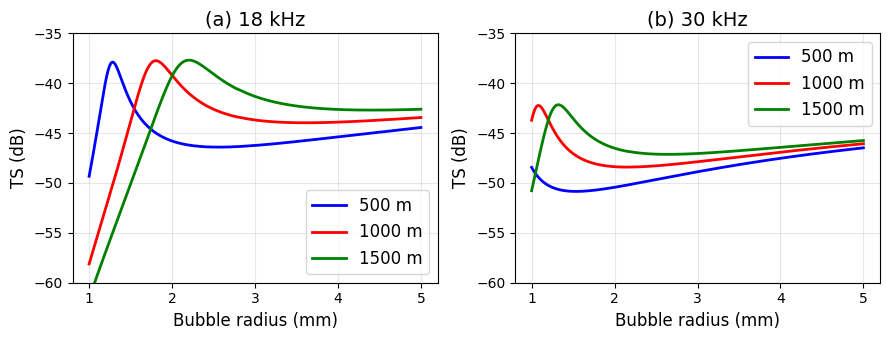

In [29]:
# Create figure reproducing Weber et al. (2014) Figure 1
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))

# Colors for different depths
colors = ['blue', 'red', 'green']
depth_labels = [f'{zi} m' for zi in z]

# Plot for 18 kHz (left panel)
for idz, zi in enumerate(z):
    depth_key = f'{zi}m'
    axs[0].plot(a * 1e3, TS_data[depth_key]['TS18'], 
                label=depth_labels[idz], color=colors[idz], linewidth=2)

axs[0].set_xlabel(r'Bubble radius (mm)', fontsize=12)
axs[0].set_ylabel('TS (dB)', fontsize=12)
axs[0].set_title('(a) 18 kHz', fontsize=14)
axs[0].set_ylim([-60, -35])
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=12)

# Plot for 30 kHz (right panel)  
for idz, zi in enumerate(z):
    depth_key = f'{zi}m'
    axs[1].plot(a * 1e3, TS_data[depth_key]['TS30'], 
                label=depth_labels[idz], color=colors[idz], linewidth=2)

axs[1].set_xlabel(r'Bubble radius (mm)', fontsize=12)
axs[1].set_ylabel('TS (dB)', fontsize=12) 
axs[1].set_title('(b) 30 kHz', fontsize=14)
axs[1].set_ylim([-60, -35])
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=12)

plt.tight_layout()

# Save plots to main plots folder only
output_path = PROJECT_ROOT / "plots" / "TS_Weber2014_validation.pdf"
output_path.parent.mkdir(exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()